# City Simlarity Test (Complete)
## Business Problem
A New York Luxury Brand has built its business in several cities in the United States, including Los Angeles, New York, and Chicago. Due to its sucess and growing popularity in these cities, the CEO and his team wants to expand their business to other cities in the United States and also explore their market in big cities in other countries, such as China and UK. Now the CEO has hired a data scientist and assigned her a task to find out the similarity between different big cities in the world and group the cities into various clusters, so that the Board of Directors can make a better decision of which business mode to operate in new cities. (For Example: If London has the been grouped into the same cluster with New York, the business mode operated in New York market will be considered for London)

In order to carry out the task, the data scientiest should make a full use of FourSquare API and collect a dataset for at least 15 cities, including those in the United States and those in other countries. Visualizations are required to present the clustering outcome so that the Board of Directors will have a clearer view of the results

## Data Section
We chose 27 most popular cities in the world and clustered them based on the three factors, venues distribution, GDP indicator, and climate types. The venues information is retrieved from FourSquare API and at most 500 venues were selected for each city, while the GDP information and climate type information are scaped from online Wikipedia pages. The GDP data is released by Brookings Institution

### Import Necessary Libraries

In [103]:
import pandas as pd
import numpy as np
import matplotlib as mpl

### Set up a World City Dataframe
The world city dataframe includes information of city names, their locations features, and their country names

In [104]:
## Create a dataframe of cities
City_data = {'City': ['New York', 'London','Edinburgh', 'Toronto', 'Sydney', 'Singapore', 'Melbourne', 'Hong Kong', 'Los Angeles', 'Chicago', 'Boston', 'San Francisco', 'Dublin', 'Washington','Beijing', 'Shanghai','Guangzhou', 'Shenzhen', 'Mumbai', 'Tokyo', 'Seoul–Incheon','Moscow','Paris', 'Taipei', 'Berlin', 'Jakarta', 'Mexico City']}
City_df = pd.DataFrame(City_data)

## add up columns of 'Lat', 'Lng', 'Country'
## For lar, and lng, we use zero values first for later data fill-in
City_df.insert(1, 'Latitude', np.zeros(27))
City_df.insert(2, 'Longitude', np.zeros(27))
City_df.insert(3, 'Country', ['US', 'UK', 'UK', 'Canada', 'Australia', 'Singapore', 'Australia', 'China', 'US', 'US', 'US', 'US', 'Ireland', 'US', 'China', 'China', 'China', 'China', 'India', 'Japan', 'South Korea', 'Russia', 'France', 'China', 'Germany', 'Indonesia', 'Mexico'])          

In [105]:
City_df.head()

,City,Latitude,Longitude,Country
0,New York,0.0,0.0,US
1,London,0.0,0.0,UK
2,Edinburgh,0.0,0.0,UK
3,Toronto,0.0,0.0,Canada
4,Sydney,0.0,0.0,Australia


### Add in Latitude & Longitude Values

In [106]:
## Imporr necessary libraries
import geopy
from geopy.geocoders import Nominatim

## use geolocation package to retrieve location features (lat & lng) into the dataframe 
for index, row in City_df.iterrows():
    city = row['City']
    geolocator = Nominatim(user_agent = "explorer2")
    location_city = geolocator.geocode(str(city))
    lat_city = location_city.latitude
    lng_city = location_city.longitude
    City_df.loc[index, 'Latitude'] = lat_city
    City_df.loc[index, 'Longitude'] = lng_city
    
City_df.head()

,City,Latitude,Longitude,Country
0,New York,40.712728,-74.006015,US
1,London,51.507322,-0.127647,UK
2,Edinburgh,55.952148,-3.188991,UK
3,Toronto,43.653963,-79.387207,Canada
4,Sydney,-33.854816,151.216454,Australia


### Visualize Locations on World Map

In [163]:
## Install relevant packages for visualization
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [164]:
## import necessary lib
import folium

## create a world map
world_map = folium.Map()

## add location marks on the world map
for lati, lngi, city in zip(City_df['Latitude'], City_df['Longitude'], City_df['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius = 3,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.6,
        parse_html = False
    ).add_to(world_map)
    
world_map

## Scrape Data
We will collect and clean data of venues, GDP, and climates step by step in this section 

### Retrive Venue Information for Cities
We retrieve at most 500 venues information for each city and add venue names and venue categories to the dataframe

In [107]:
## import necessary packages
import requests

## Client Information for Foursquare
CLIENT_ID = "331QIXI5YMKN20D3VHINKUKY5SRMBZHMS5S2WLB0YATWN21J"
CLIENT_SECRET = "KSDVCZ554PWN1244NW4FF4OF3H10FJRI5AZ0WLRBH3X4SY1X"
VERSION = '20190829'
LIMIT = 500

In [108]:
## Create a function to repeat process for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url_city = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url_city).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return nearby_venues

In [109]:
## Fill in the location inforation of cities into the function and return a segregated dataframe of venues for all cities
world_venues = getNearbyVenues(names = City_df['City'], latitudes = City_df['Latitude'], longitudes = City_df['Longitude'])
world_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,New York,40.712728,-74.006015,Four Seasons Hotel New York Downtown,40.712612,-74.009380,Hotel
2,New York,40.712728,-74.006015,Korin,40.714824,-74.009404,Furniture / Home Store
3,New York,40.712728,-74.006015,Aire Ancient Baths,40.718141,-74.004941,Spa
4,New York,40.712728,-74.006015,9/11 Memorial North Pool,40.712077,-74.013187,Memorial Site


In [110]:
## Check out the size of the dataset
world_venues.shape

(2700, 7)

### Analysis for the Venue Distribution in Cities
We will figure out the top 10 popular venues in each city for viewing

In [111]:
## Apply onehot-coding to venue categories 
world_onehot = pd.get_dummies(world_venues['Venue Category'], prefix = "", prefix_sep= "")
world_onehot.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
## Add city column back to dataframe
world_onehot[['City']] = world_venues[['City']]

# move city column to the first column
fixed_columns = [world_onehot.columns[-1]] + list(world_onehot.columns[:-1])
world_onehot_city = world_onehot[fixed_columns]

world_onehot_city.head()

,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
## Group the dataset by the city names to check out the percentage of each venue categores 
world_grouped = world_onehot_city.groupby('City').mean().reset_index()
world_grouped.head()

,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Beijing,0.0,0.0,0.0,0.01,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.04,0.01,0.0
1,Berlin,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,...,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.0
2,Boston,0.0,0.0,0.0,0.01,0.00,0.01,0.00,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0
3,Chicago,0.0,0.0,0.0,0.01,0.01,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0
4,Dublin,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0


In [173]:
## Define a function that sorts the values in rows

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [211]:
## create columns according to number of top venues
columns = ['City']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

## Create a dataframe
## set up the column names for the dataframe
City_venue_sorted = pd.DataFrame(columns = columns)

## set the column of "City" 
City_venue_sorted['City'] = world_grouped['City']

## Set the other column values -- the top 10 venue names
for ind in np.arange(world_grouped.shape[0]):
    City_venue_sorted.iloc[ind, 1:] = return_most_common_venues(world_grouped.iloc[ind, :], 10)

City_venue_sorted

,City,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beijing,Historic Site,Hotel,Park,Chinese Restaurant,Yunnan Restaurant,Café,Coffee Shop,Hostel,Temple,Peking Duck Restaurant
1,Berlin,Coffee Shop,Bookstore,Park,Ice Cream Shop,Concert Hall,Sandwich Place,Garden,Bakery,Hotel,Wine Bar
2,Boston,Park,Bakery,Hotel,Seafood Restaurant,Theater,Mexican Restaurant,Historic Site,Gym,Pizza Place,Gastropub
3,Chicago,Hotel,Park,Theater,Italian Restaurant,Coffee Shop,New American Restaurant,Boat or Ferry,Mediterranean Restaurant,Restaurant,Burger Joint
4,Dublin,Coffee Shop,Café,Pub,Restaurant,Park,Cocktail Bar,Burger Joint,Hotel,Italian Restaurant,Indie Movie Theater
5,Edinburgh,Café,Coffee Shop,Bar,Hotel,French Restaurant,Park,Cocktail Bar,Museum,Pub,Whisky Bar
6,Guangzhou,Hotel,Coffee Shop,Park,Shopping Mall,Chinese Restaurant,Turkish Restaurant,Restaurant,Cantonese Restaurant,Electronics Store,Cocktail Bar
7,Hong Kong,Hotel,Bar,Japanese Restaurant,Italian Restaurant,Gym / Fitness Center,Scenic Lookout,Cocktail Bar,Lounge,Café,Steakhouse
8,Jakarta,Hotel,Coffee Shop,Restaurant,Shopping Mall,Indonesian Restaurant,Dessert Shop,Sushi Restaurant,Food Truck,Asian Restaurant,Buffet
9,London,Hotel,Cocktail Bar,Theater,Art Museum,Park,Bookstore,Department Store,Coffee Shop,Hotel Bar,Clothing Store


### Scrape Data of City GDP from Online
We used the data available on the wikipedia page with a list of cities with ther GDP estimations in 2014. The data are released by Brookings Institution.

In [116]:
## Import necessary lib
import pandas as pd
import requests
from bs4 import BeautifulSoup

## scrape datasets from website -- wikipedia page table
res = requests.get("https://en.wikipedia.org/wiki/List_of_cities_by_GDP")
soup = BeautifulSoup(res.content, 'lxml')
table = soup.find_all('table')[0]
City_GDP = pd.read_html(str(table))
City_GDP_dp = City_GDP[0][['City/Metropolitan area', 'Brookings Institution[2]2014 est.PPP-adjustedGDP ($BN)']]
City_GDP_dp.head()


,City/Metropolitan area,Brookings Institution[2]2014 est.PPP-adjustedGDP ($BN)
0,Aachen-Liège-Maastricht,99.7
1,Aberdeen,NaN
2,Abidjan,NaN
3,Abu Dhabi,178.3
4,Addis Ababa,NaN


In [117]:
## Change the column names for convenience
City_GDP_dp.columns = ['City', 'GDP']

## convert city names in world_grouped dataframe into a list
city_list = world_grouped['City'].tolist()

## Filter out data for relevant cities
gdp_filtered = []
for index, row in City_GDP_dp.iterrows():
    if row['City'] in city_list:
        gdp_filtered.append([row['City'], row['GDP']])

## print out city names that match >> turn out there are two cities that are not matched in the dataframe >> Seoul–Incheon & Washington
gdp_filtered

[['Beijing', '506.1'],
 ['Berlin', '157.7'],
 ['Boston', '360.1'],
 ['Chicago', '563.2'],
 ['Dublin', '90.1'],
 ['Edinburgh', '32.5'],
 ['Guangzhou', '380.3'],
 ['Hong Kong', '416.0'],
 ['Jakarta', '321.3'],
 ['London', '835.7'],
 ['Los Angeles', '860.5'],
 ['Melbourne', '178.4'],
 ['Mexico City', '403.6'],
 ['Moscow', '553.3'],
 ['Mumbai', '150.9'],
 ['New York', '1403'],
 ['Paris', '715.1'],
 ['San Francisco', '331.0'],
 ['Shanghai', '594.0'],
 ['Shenzhen', '363.2'],
 ['Singapore', '365.9'],
 ['Sydney', '223.4'],
 ['Taipei', '327.3'],
 ['Tokyo', '1617'],
 ['Toronto', '276.3']]

In [118]:
## Add up the two cities -- Seoul–Incheon & Washington into the list
for index, row in City_GDP_dp.iterrows():
    if row['City'] in ['Washington, DC', 'Seoul']:
        gdp_filtered.append([row['City'], row['GDP']])

## Convert the list into a dataframe 
gdp_filtered_df = pd.DataFrame(gdp_filtered)
gdp_filtered_df.columns = ['City', 'GDP']

## drop repeated rows in the dataframe and convert GDP column into float
gdp_filtered_df = pd.DataFrame(gdp_filtered_df.drop_duplicates())
gdp_filtered_df['GDP'] = pd.to_numeric(gdp_filtered_df['GDP'])

In [119]:
## have a look at the dataset
gdp_filtered_df.head()

,City,GDP
0,Beijing,506.1
1,Berlin,157.7
2,Boston,360.1
3,Chicago,563.2
4,Dublin,90.1


### Rank Cities in GDP Values

In [120]:
## Rank Cities in GDP values and sort values
gdp_filtered_sorted = gdp_filtered_df.sort_values('GDP', ascending = False)
gdp_filtered_sorted.head(10)

,City,GDP
23,Tokyo,1617.0
15,New York,1403.0
10,Los Angeles,860.5
25,Seoul,845.9
9,London,835.7
16,Paris,715.1
18,Shanghai,594.0
3,Chicago,563.2
13,Moscow,553.3
0,Beijing,506.1


In [121]:
## The last 5 cities in rank of GDP
gdp_filtered_sorted.tail(5)

,City,GDP
11,Melbourne,178.4
1,Berlin,157.7
14,Mumbai,150.9
4,Dublin,90.1
5,Edinburgh,32.5


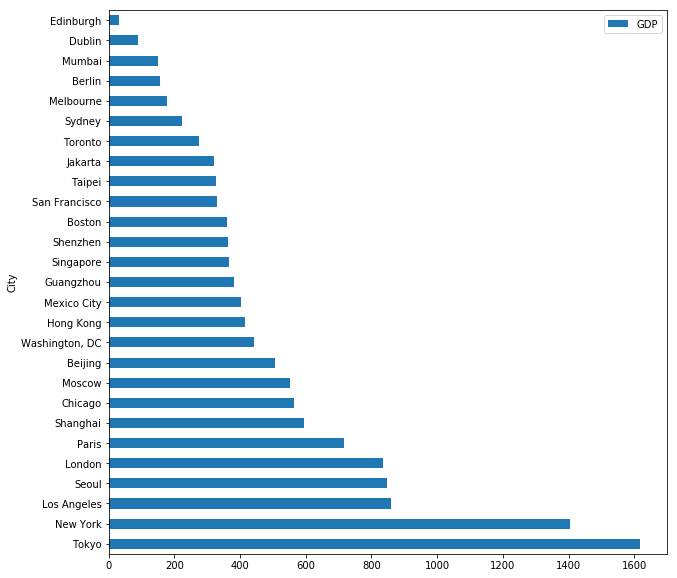

In [122]:
## Visualize the ranking with a bar chart
gdp_visualize = gdp_filtered_sorted
gdp_visualize = gdp_visualize.set_index('City')
import matplotlib as mpl
gdp_visualize.plot(kind = 'barh',
                        figsize = (10, 10))

### Normalize GDP data for modeling

In [123]:
## reset index for GDP dataset
gdp_filtered_sorted1 = gdp_filtered_sorted.reset_index().drop(['index'], axis = 1)

In [124]:
## import necessary libs
from sklearn import preprocessing

## Standardize datasets
scaler = preprocessing.StandardScaler()
gdp_array = np.array(gdp_filtered_sorted['GDP'])
gdp_normalized_array = preprocessing.normalize([gdp_array])

## add the normalized gdp back into the dataframe
gdp_column = pd.DataFrame(gdp_normalized_array).transpose()
gdp_filtered_sorted1.insert(1, 'Normalized GDP', gdp_column)
gdp_filtered_sorted1.head()

,City,Normalized GDP,GDP
0,Tokyo,0.509116,1617.0
1,New York,0.441738,1403.0
2,Los Angeles,0.270930,860.5
3,Seoul,0.266333,845.9
4,London,0.263122,835.7


### Scrape Data of Climates/Temperature from Online
We used the data available on the wikipedia page with a list of cities with their annual average temperature, which could be a reliable indicator of their climate differences

In [125]:
## scrape datasets from website -- wikipedia page table
import requests
from bs4 import BeautifulSoup
import pandas as pd

## scrape data from the Wikipedia avergae temperature page
res1 = requests.get("https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature")
soup1 = BeautifulSoup(res1.content, 'lxml')

## scrape Asia table
table_Asia = soup1.find_all('table')[1]
Asia_temp = pd.read_html(str(table_Asia))[0]

## scrape Europe table
table_Europe = soup1.find_all('table')[2]
Europe_temp = pd.read_html(str(table_Europe))[0]

## scrape America table
table_America = soup1.find_all('table')[3]
America_temp = pd.read_html(str(table_America))[0]

## scrape Australia table
table_Australia = soup1.find_all('table')[4]
Australia_temp = pd.read_html(str(table_Australia))[0]

Australia_temp.tail()

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
21,New Zealand,Wellington,16.9(62.4),17.2(63.0),15.8(60.4),13.7(56.7),11.7(53.1),9.7(49.5),8.9(48.0),9.4(48.9),10.8(51.4),12.0(53.6),13.5(56.3),15.4(59.7),12.9(55.2),[338]
22,Papua New Guinea,Port Moresby,27.4(81.3),27.3(81.1),27.1(80.8),27.0(80.6),26.9(80.4),26.1(79.0),25.7(78.3),26.1(79.0),26.5(79.7),27.5(81.5),27.6(81.7),27.8(82.0),26.9(80.4),[339]
23,Solomon Islands,Honiara,26.7(80.1),26.6(79.9),26.6(79.9),26.5(79.7),26.6(79.9),26.4(79.5),26.1(79.0),26.2(79.2),26.5(79.7),26.5(79.7),26.7(80.1),26.8(80.2),26.5(79.7),[340]
24,United States,Honolulu,22.9(73.2),22.9(73.2),23.7(74.7),24.6(76.3),25.6(78.1),26.8(80.2),27.4(81.3),27.8(82.0),27.6(81.7),26.8(80.2),25.4(77.7),23.8(74.8),25.4(77.7),[341]
25,Vanuatu,Port Vila,26.4(79.5),26.5(79.7),26.3(79.3),25.3(77.5),24.1(75.4),23.0(73.4),22.1(71.8),22.0(71.6),22.7(72.9),23.4(74.1),24.6(76.3),25.7(78.3),24.3(75.7),[342]


In [126]:
## set up a list to store relevant data
temp_list = []

## Filter out data for relevant cities >> in Asia
for index, row in Asia_temp.iterrows():
    if row['City'] in city_list:
        temp_list.append([row['City'], row['Year']])

## Filter out data for relevant cities >> in Europe
for index, row in Europe_temp.iterrows():
    if row['City'] in city_list:
        temp_list.append([row['City'], row['Year']])       
 
 ## Filter out data for relevant cities >> in America
for index, row in America_temp.iterrows():
    if row['City'] in city_list:
        temp_list.append([row['City'], row['Year']])  

## Filter out data for relevant cities >> in Australia
for index, row in Australia_temp.iterrows():
    if row['City'] in city_list:
        temp_list.append([row['City'], row['Year']])  

## check if data for all cities are successfully extracted
len(temp_list)

21

In [127]:
## check out which cities are missing
temp_list

[['Beijing', '12.9(55.2)'],
 ['Shanghai', '16.7(62.1)'],
 ['Hong Kong', '23.3(73.9)'],
 ['Mumbai', '27.1(80.8)'],
 ['Jakarta', '26.7(80.1)'],
 ['Tokyo', '15.4(59.7)'],
 ['Singapore', '27(81)'],
 ['Taipei', '23.0(73.4)'],
 ['Paris', '12.3(54.1)'],
 ['Berlin', '10.3(50.5)'],
 ['Dublin', '9.8(49.6)'],
 ['Moscow', '5.8(42.4)'],
 ['Edinburgh', '9.3(48.7)'],
 ['London', '10.3(50.5)'],
 ['Toronto', '9.4(48.9)'],
 ['Mexico City', '17.5(63.5)'],
 ['Boston', '10.9(51.7)'],
 ['Chicago', '10.8(51.4)'],
 ['Los Angeles', '17.4(63.3)'],
 ['Melbourne', '15.1(59.2)'],
 ['Sydney', '17.7(63.9)']]

In [128]:
## add up the missing cities
## Seoul
for index, row in Asia_temp.iterrows():
    if row['City'] in ['Seoul']:
        temp_list.append(['Seoul–Incheon', row['Year']])
        
## Washington,D.C., San Francisco, New York City
for index, row in America_temp.iterrows():
    if row['City'] in ['New York City' ]:
        temp_list.append(['New York', row['Year']])  
        
## Manually add up the rest from online sources
temp_list.append(['San Francisco', '14.6()'])
temp_list.append(['Washinton DC', '14.6()'])
temp_list.append(['Shenzhen', '22.9()'])
temp_list.append(['Guangzhou', '22.2()'])
        
len(temp_list)

27

In [129]:
## convert temp_list into a dataframe
temp_df = pd.DataFrame(temp_list)
temp_df.columns = ['City', 'Temperature']

## drop out the F temp in the ()
for index, row in temp_df.iterrows():
    row['Temperature'] = row['Temperature'].split('(')[0]

## convert temperature values into int
temp_df['Temperature'] = pd.to_numeric(temp_df['Temperature'])

temp_df.head()

,City,Temperature
0,Beijing,12.9
1,Shanghai,16.7
2,Hong Kong,23.3
3,Mumbai,27.1
4,Jakarta,26.7


### Rank Cities in Temperature Values

In [130]:
## Rank Cities in Temperature values and sort values
temp_sorted = temp_df.sort_values('Temperature', ascending = False)
temp_sorted.head(10)

,City,Temperature
3,Mumbai,27.1
6,Singapore,27.0
4,Jakarta,26.7
2,Hong Kong,23.3
7,Taipei,23.0
25,Shenzhen,22.9
26,Guangzhou,22.2
20,Sydney,17.7
15,Mexico City,17.5
18,Los Angeles,17.4


In [131]:
## The last 10 cities in rank of tempature
temp_sorted.tail(10)

,City,Temperature
21,Seoul–Incheon,12.5
8,Paris,12.3
16,Boston,10.9
17,Chicago,10.8
9,Berlin,10.3
13,London,10.3
10,Dublin,9.8
14,Toronto,9.4
12,Edinburgh,9.3
11,Moscow,5.8


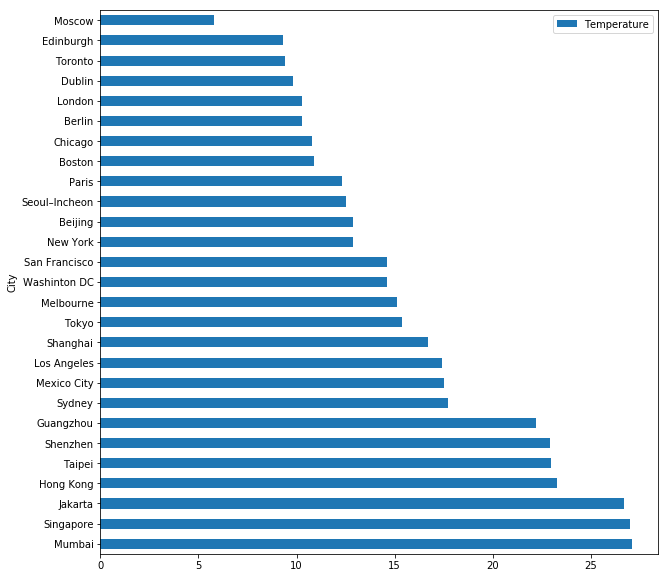

In [132]:
## Visualize the ranking with a bar chart
temp_visualize = temp_sorted
temp_visualize = temp_visualize.set_index('City')
temp_visualize.plot(kind = 'barh',
                   figsize = (10, 10))

### Normalize Temperature data for modeling

In [133]:
## reset index for Temperature dataset
temp_sorted = temp_sorted.reset_index().drop(['index'], axis = 1)

In [134]:
## Standardize datasets
scaler_temp = preprocessing.StandardScaler()
temp_array = np.array(temp_sorted['Temperature'])
temp_normalized_array = preprocessing.normalize([temp_array])

## add the normalized gdp back into the dataframe
temp_column = pd.DataFrame(temp_normalized_array).transpose()
temp_sorted.insert(1, 'Normalized Temperature', temp_column)
temp_sorted.head()

,City,Normalized Temperature,Temperature
0,Mumbai,0.307823,27.1
1,Singapore,0.306687,27.0
2,Jakarta,0.303279,26.7
3,Hong Kong,0.264659,23.3
4,Taipei,0.261252,23.0


### Merge All Features -- Venue Distribution, GDP & Climate
We will merge all data into one dataframe for convenience

In [205]:
## make sure the city names are the same
gdp_filtered_sorted1= gdp_filtered_sorted1.replace('Seoul-Incheon', 'Seoul')
gdp_filtered_sorted1 = gdp_filtered_sorted1.replace('Washington, DC', 'Washington')
temp_sorted = temp_sorted.replace('Washinton DC', 'Washington')
temp_sorted = temp_sorted.replace('Seoul–Incheon', 'Seoul')
world_grouped = world_grouped.replace('Seoul–Incheon', 'Seoul')

In [206]:
## merge GDP data
world_merged_cluster = world_grouped
world_merged_cluster = world_merged_cluster.join(gdp_filtered_sorted1.set_index('City'), on = 'City')

# merge Temperature data
world_merged_cluster = world_merged_cluster.join(temp_sorted.set_index('City'), on = 'City')
world_merged_cluster.head()

,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Normalized GDP,GDP,Normalized Temperature,Temperature
0,Beijing,0.0,0.0,0.0,0.01,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,0.0,0.04,0.01,0.0,0.159347,506.1,0.146528,12.9
1,Berlin,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,...,0.0,0.01,0.0,0.00,0.00,0.0,0.049652,157.7,0.116995,10.3
2,Boston,0.0,0.0,0.0,0.01,0.00,0.01,0.00,0.0,0.00,...,0.0,0.02,0.0,0.00,0.00,0.0,0.113378,360.1,0.123811,10.9
3,Chicago,0.0,0.0,0.0,0.01,0.01,0.00,0.00,0.0,0.00,...,0.0,0.02,0.0,0.00,0.00,0.0,0.177325,563.2,0.122675,10.8
4,Dublin,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.028368,90.1,0.111316,9.8


In [207]:
## Drop GDP and Temperature columns
world_merged_cluster = world_merged_cluster.drop(['GDP', 'Temperature'], axis = 1)
world_merged_cluster.head()

,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Normalized GDP,Normalized Temperature
0,Beijing,0.0,0.0,0.0,0.01,0.00,0.00,0.00,0.0,0.00,...,0.0,0.01,0.0,0.00,0.0,0.04,0.01,0.0,0.159347,0.146528
1,Berlin,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.01,...,0.0,0.00,0.0,0.01,0.0,0.00,0.00,0.0,0.049652,0.116995
2,Boston,0.0,0.0,0.0,0.01,0.00,0.01,0.00,0.0,0.00,...,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.113378,0.123811
3,Chicago,0.0,0.0,0.0,0.01,0.01,0.00,0.00,0.0,0.00,...,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.177325,0.122675
4,Dublin,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.0,0.00,...,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.028368,0.111316


### Add weights to different factors
In order for different factors to be weighted diferently in the model, we will adjust the scale for normalized GDP and normalized temperature. We will assign 2 times to normalized GDP and 2 times to normalized Temperature

In [208]:
## 10 times to normalized GDP
world_merged_cluster['Normalized GDP'] = world_merged_cluster['Normalized GDP']*1.5
world_merged_cluster['Normalized Temperature'] = world_merged_cluster['Normalized Temperature']*1.5
world_merged_cluster

,City,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Normalized GDP,Normalized Temperature
0,Beijing,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.04,0.01,0.00,0.239020,0.219792
1,Berlin,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.074478,0.175493
2,Boston,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.170067,0.185716
3,Chicago,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.265987,0.184012
4,Dublin,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.042552,0.166974
5,Edinburgh,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.015349,0.158455
6,Guangzhou,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.179607,0.378247
7,Hong Kong,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.01,0.196468,0.396989
8,Jakarta,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.151743,0.454919
9,London,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.394683,0.175493


### Set Up and Train the Model
We will use the onehot-coded grouped data to fit a kmeans clustering model 

In [209]:
## Drop out the city column of the grouped data for model training
world_grouped_clustering = world_merged_cluster.drop(['City'], axis = 1)

## import machine learning packages
import sklearn
from sklearn.cluster import KMeans

## Create and fit a kmeans model 
model_kmeans = KMeans(n_clusters = 6, random_state = 0)
model_kmeans.fit(world_grouped_clustering)

## Check out the labels
kmeans_labels = model_kmeans.labels_
kmeans_labels

array([5, 4, 2, 1, 4, 4, 0, 0, 0, 1, 1, 4, 2, 1, 0, 3, 1, 2, 1, 1, 0, 0,
       4, 0, 3, 4, 2], dtype=int32)

### Update the Dataframe with Cluster Labels and Location Features
We will add the cluster labels to the dataframe -- City_venue_sorted


In [212]:
## Add Clustering labels 
City_venue_sorted.insert(0, 'Cluster Labels', kmeans_labels)
City_venue_sorted.head()

,Cluster Labels,City,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Beijing,Historic Site,Hotel,Park,Chinese Restaurant,Yunnan Restaurant,Café,Coffee Shop,Hostel,Temple,Peking Duck Restaurant
1,4,Berlin,Coffee Shop,Bookstore,Park,Ice Cream Shop,Concert Hall,Sandwich Place,Garden,Bakery,Hotel,Wine Bar
2,2,Boston,Park,Bakery,Hotel,Seafood Restaurant,Theater,Mexican Restaurant,Historic Site,Gym,Pizza Place,Gastropub
3,1,Chicago,Hotel,Park,Theater,Italian Restaurant,Coffee Shop,New American Restaurant,Boat or Ferry,Mediterranean Restaurant,Restaurant,Burger Joint
4,4,Dublin,Coffee Shop,Café,Pub,Restaurant,Park,Cocktail Bar,Burger Joint,Hotel,Italian Restaurant,Indie Movie Theater


In [213]:
## Check out the shape of the City_venue_sorted
City_venue_sorted.shape

(27, 12)

In [214]:
## Check out the shape of the Toronto_selected
City_df.shape

(27, 4)

In [235]:
## Since the two dataframes have the same shape, we can merge them on the Postal Code
City_venue_sorted = City_venue_sorted.replace('Seoul–Incheon', 'Seoul')
world_merged = City_df
world_merged = world_merged.replace('Seoul–Incheon', 'Seoul')
world_merged = world_merged.join(City_venue_sorted.set_index('City'), on = 'City')

world_merged

,City,Latitude,Longitude,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,40.712728,-74.006015,US,3,Park,Cycle Studio,Ice Cream Shop,Bookstore,Scenic Lookout,Italian Restaurant,Gym,Theater,Wine Shop,Yoga Studio
1,London,51.507322,-0.127647,UK,1,Hotel,Cocktail Bar,Theater,Art Museum,Park,Bookstore,Department Store,Coffee Shop,Hotel Bar,Clothing Store
2,Edinburgh,55.952148,-3.188991,UK,4,Café,Coffee Shop,Bar,Hotel,French Restaurant,Park,Cocktail Bar,Museum,Pub,Whisky Bar
3,Toronto,43.653963,-79.387207,Canada,4,Coffee Shop,Café,Restaurant,Hotel,Park,Japanese Restaurant,Pizza Place,Yoga Studio,Sandwich Place,Italian Restaurant
4,Sydney,-33.854816,151.216454,Australia,4,Café,Park,Theater,Coffee Shop,Scenic Lookout,Hotel,Bakery,Cocktail Bar,Thai Restaurant,Italian Restaurant
5,Singapore,1.340853,103.878447,Singapore,0,Hotel,Park,Ice Cream Shop,Bakery,Supermarket,Event Space,Performing Arts Venue,Steakhouse,Trail,Buffet
6,Melbourne,-37.814218,144.963161,Australia,4,Coffee Shop,Café,Cocktail Bar,Park,Wine Bar,Ice Cream Shop,Italian Restaurant,Asian Restaurant,Theater,Music Venue
7,Hong Kong,22.279328,114.162813,China,0,Hotel,Bar,Japanese Restaurant,Italian Restaurant,Gym / Fitness Center,Scenic Lookout,Cocktail Bar,Lounge,Café,Steakhouse
8,Los Angeles,34.053691,-118.242767,US,1,Coffee Shop,Brewery,Theater,Taco Place,Ice Cream Shop,Hotel,American Restaurant,Bookstore,Sushi Restaurant,Art Gallery
9,Chicago,41.875562,-87.624421,US,1,Hotel,Park,Theater,Italian Restaurant,Coffee Shop,New American Restaurant,Boat or Ferry,Mediterranean Restaurant,Restaurant,Burger Joint


### Visualize the Cluster Results on the Map
We will visualize the map with different clusters results with different colors

In [236]:
## import necessary lib and packages
import matplotlib.cm as cm
import matplotlib.colors as colors

## Create map
map_clusters = folium.Map()

## set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, country,cluster in zip(world_merged['Latitude'], world_merged['Longitude'], world_merged['City'], world_merged['Country'],world_merged['Cluster Labels']):
    label = folium.Popup(str(city) + ',' + str(country) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## Conlusion
Based on the analysis above, a total of 27 cities were clustered into 5 groups and the Board of Directors can make an informed decision based on this result. Let's have a look at which cities are more similar than others

### Cluster 0

In [225]:
## Filter out the cluster 0 cities and change the column name to cluster 0
Cluster0 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 0][['City', 'Country']])
Cluster0.columns = ['City', 'Country']
Cluster0 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 0][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster0.columns = ['City', 'Country']
Cluster0 = Cluster0.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster0 = Cluster0.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster0 = Cluster0.join(temp_sorted.set_index('City'), on = 'City')
Cluster0

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
5,Singapore,Singapore,0,Hotel,Park,Ice Cream Shop,Bakery,Supermarket,Event Space,Performing Arts Venue,Steakhouse,Trail,Buffet,0.115204,365.9,0.306687,27.0
7,Hong Kong,China,0,Hotel,Bar,Japanese Restaurant,Italian Restaurant,Gym / Fitness Center,Scenic Lookout,Cocktail Bar,Lounge,Café,Steakhouse,0.130978,416.0,0.264659,23.3
16,Guangzhou,China,0,Hotel,Coffee Shop,Park,Shopping Mall,Chinese Restaurant,Turkish Restaurant,Restaurant,Cantonese Restaurant,Electronics Store,Cocktail Bar,0.119738,380.3,0.252165,22.2
17,Shenzhen,China,0,Hotel,Coffee Shop,Shopping Mall,Café,Chinese Restaurant,Park,Hotpot Restaurant,Japanese Restaurant,Bookstore,Electronics Store,0.114354,363.2,0.260116,22.9
18,Mumbai,India,0,Indian Restaurant,Café,Hotel,Ice Cream Shop,Dessert Shop,Pizza Place,Fast Food Restaurant,Coffee Shop,Italian Restaurant,Bakery,0.047511,150.9,0.307823,27.1
23,Taipei,China,0,Hotel,Café,Dessert Shop,Japanese Restaurant,Bakery,Dumpling Restaurant,Noodle House,Bookstore,Park,Mountain,0.103051,327.3,0.261252,23.0
25,Jakarta,Indonesia,0,Hotel,Coffee Shop,Restaurant,Shopping Mall,Indonesian Restaurant,Dessert Shop,Sushi Restaurant,Food Truck,Asian Restaurant,Buffet,0.101162,321.3,0.303279,26.7


In [228]:
Cluster0.shape

(7, 17)

These 7 cities are all located in the southern Asian areas with similar climates and temperatures. Their GDP are close too and are lower than those of the cluster 1 cities. 6 of them have hotel as the most common venue and coffee shops/cafe are very popular too. This shows that tourism might be an essential source of income for these cities 

### Cluster 1

In [217]:
## Filter out the cluster 1 cities and change the column name to cluster 1
City_venue_sorted = City_venue_sorted.replace('Seoul–Incheon', 'Seoul')
Cluster1 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 1][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster1.columns = ['City', 'Country']
Cluster1 = Cluster1.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster1 = Cluster1.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster1 = Cluster1.join(temp_sorted.set_index('City'), on = 'City')
Cluster1

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
1,London,UK,1,Hotel,Cocktail Bar,Theater,Art Museum,Park,Bookstore,Department Store,Coffee Shop,Hotel Bar,Clothing Store,0.263122,835.7,0.116995,10.3
8,Los Angeles,US,1,Coffee Shop,Brewery,Theater,Taco Place,Ice Cream Shop,Hotel,American Restaurant,Bookstore,Sushi Restaurant,Art Gallery,0.270930,860.5,0.197643,17.4
9,Chicago,US,1,Hotel,Park,Theater,Italian Restaurant,Coffee Shop,New American Restaurant,Boat or Ferry,Mediterranean Restaurant,Restaurant,Burger Joint,0.177325,563.2,0.122675,10.8
15,Shanghai,China,1,Hotel,Hotel Bar,Lounge,Dumpling Restaurant,French Restaurant,Italian Restaurant,Café,Chinese Restaurant,Scenic Lookout,Shopping Mall,0.187022,594.0,0.189691,16.7
21,Moscow,Russia,1,Yoga Studio,Hotel,Theater,Park,Pizza Place,Garden,Road,Jewelry Store,Coffee Shop,Art Gallery,0.174208,553.3,0.065881,5.8
22,Paris,France,1,Plaza,Cocktail Bar,Hotel,Italian Restaurant,Seafood Restaurant,Bookstore,Wine Bar,Bistro,Ice Cream Shop,Art Museum,0.225151,715.1,0.139713,12.3


In [226]:
# Count how many cities in cluster 1
Cluster1.shape

(6, 17)

These 6 cities are from all across the world. One common feature among them is that theaters are pretty popular in these cities. London, LA, Chicago, and Moscow are four out of five cities among all with theaters in the top 3 most common venues, and they all have developed arts and entertainment industries. Besides, Hotels are popular in these cities and all 6 cities all have close GDP, which is nearly 2 times higher than that of cluster 0 cities. However, their climates are pretty different. 

### Cluster 2

In [237]:
## Filter out the cluster 2 cities and change the column name to cluster 2
Cluster2 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 2][['City', 'Country']])
Cluster2.columns = ['City', 'Country']
Cluster2 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 2][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster2.columns = ['City', 'Country']
Cluster2 = Cluster2.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster2 = Cluster2.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster2 = Cluster2.join(temp_sorted.set_index('City'), on = 'City')
Cluster2

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
10,Boston,US,2,Park,Bakery,Hotel,Seafood Restaurant,Theater,Mexican Restaurant,Historic Site,Gym,Pizza Place,Gastropub,0.113378,360.1,0.123811,10.9
11,San Francisco,US,2,Park,Coffee Shop,Yoga Studio,Grocery Store,Ice Cream Shop,Marijuana Dispensary,Gym,Dance Studio,Wine Bar,Bakery,0.104216,331.0,0.165838,14.6
13,Washington,US,2,Monument / Landmark,Hotel,Art Museum,Coffee Shop,History Museum,Theater,Salon / Barbershop,American Restaurant,Science Museum,Mediterranean Restaurant,0.139228,442.2,0.165838,14.6
26,Mexico City,Mexico,2,Ice Cream Shop,Mexican Restaurant,Art Museum,Hotel,Park,Coffee Shop,Public Art,Seafood Restaurant,Spa,Bakery,0.127074,403.6,0.198778,17.5


In this cluster, 3 cities are from the United States and all 4 cities are located in the American continents. Their popular venues include parks and museums, which shows people in these cities are enjoying a rather slowly-paced life. These cities have a similar GDP too, which is slightly higher than that of cluster 0 but much lower than that of cluster 1

### Cluster 3

In [238]:
## Filter out the cluster 3 cities and change the column name to cluster 3
Cluster3 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 3][['City', 'Country']])
Cluster3.columns = ['City', 'Country']
Cluster3 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 3][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster3.columns = ['City', 'Country']
Cluster3 = Cluster3.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster3 = Cluster3.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster3 = Cluster3.join(temp_sorted.set_index('City'), on = 'City')
Cluster3

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
0,New York,US,3,Park,Cycle Studio,Ice Cream Shop,Bookstore,Scenic Lookout,Italian Restaurant,Gym,Theater,Wine Shop,Yoga Studio,0.441738,1403.0,0.146528,12.9
19,Tokyo,Japan,3,Hotel,Sake Bar,Tonkatsu Restaurant,Kaiseki Restaurant,BBQ Joint,Chinese Restaurant,Wagashi Place,Coffee Shop,Japanese Curry Restaurant,Garden,0.509116,1617.0,0.174925,15.4


In [220]:
# Count how many cities in cluster 3
Cluster3.shape

(2, 2)

This cluster only has 2 cities, one in East Asia and the other in North America. These 2 cities have the highest GDP among all cities, and have similar climates too. However, their venue distribution are quite similar. Restaurants take up a large portion of venues in Tokyo, while venues in New York are pretty diverse

### Cluster 4

In [239]:
## Filter out the cluster 4 cities and change the column name to cluster 4
Cluster4 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 4][['City', 'Country']])
Cluster4.columns = ['City', 'Country']
Cluster4 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 4][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster4 = Cluster4.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster4 = Cluster4.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster4 = Cluster4.join(temp_sorted.set_index('City'), on = 'City')
Cluster4

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
2,Edinburgh,UK,4,Café,Coffee Shop,Bar,Hotel,French Restaurant,Park,Cocktail Bar,Museum,Pub,Whisky Bar,0.010233,32.5,0.105637,9.3
3,Toronto,Canada,4,Coffee Shop,Café,Restaurant,Hotel,Park,Japanese Restaurant,Pizza Place,Yoga Studio,Sandwich Place,Italian Restaurant,0.086994,276.3,0.106772,9.4
4,Sydney,Australia,4,Café,Park,Theater,Coffee Shop,Scenic Lookout,Hotel,Bakery,Cocktail Bar,Thai Restaurant,Italian Restaurant,0.070338,223.4,0.201050,17.7
6,Melbourne,Australia,4,Coffee Shop,Café,Cocktail Bar,Park,Wine Bar,Ice Cream Shop,Italian Restaurant,Asian Restaurant,Theater,Music Venue,0.056170,178.4,0.171517,15.1
12,Dublin,Ireland,4,Coffee Shop,Café,Pub,Restaurant,Park,Cocktail Bar,Burger Joint,Hotel,Italian Restaurant,Indie Movie Theater,0.028368,90.1,0.111316,9.8
24,Berlin,Germany,4,Coffee Shop,Bookstore,Park,Ice Cream Shop,Concert Hall,Sandwich Place,Garden,Bakery,Hotel,Wine Bar,0.049652,157.7,0.116995,10.3


In [240]:
Cluster4.shape

(6, 17)

This cluster has the lowest GDP among all clusters. Most cities are located in Europe and Australia. The similarity among these cities is that they are western countries and people in these cities generally enjoy a western lifestyle. They are unlike cities such as London or LA, which are more international and their popular venues are coffee shops, parks, and bars. 

### Cluster 5

In [241]:
## Filter out the cluster 5 cities and change the column name to cluster 5
Cluster5 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 5][['City', 'Country']])
Cluster5.columns = ['City', 'Country']
Cluster5 = pd.DataFrame(world_merged[world_merged['Cluster Labels'] == 5][['City', 'Country']]).replace('Seoul–Incheon','Seoul')
Cluster5 = Cluster5.join(City_venue_sorted.set_index('City'), on = 'City')
Cluster5 = Cluster5.join(gdp_filtered_sorted1.set_index('City'), on = 'City')
Cluster5 = Cluster5.join(temp_sorted.set_index('City'), on = 'City')
Cluster5

,City,Country,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Normalized GDP,GDP,Normalized Temperature,Temperature
14,Beijing,China,5,Historic Site,Hotel,Park,Chinese Restaurant,Yunnan Restaurant,Café,Coffee Shop,Hostel,Temple,Peking Duck Restaurant,0.159347,506.1,0.146528,12.9


Beijing is the only city in this cluster. Its GDP value and Average Annual Temperature value are in the middle. However, its venue distribution is rather unique compared to other cities. It is the only city with historic site as the most common venue, and also the only city with Yunnan and Pecking duck restaurants in the top 10 venues. This shows Beijing is a rather cultured and unique city differented with other cities.  